In [1]:
%matplotlib inline
import numpy as np
import cv2
from mss import mss
from PIL import Image
import matplotlib.pyplot as plt
import time
import pyautogui
from scipy import stats
import pickle
import copy
from directkeys import PressKey,ReleaseKey,U,D,L,R,Z,CTRL
print(pyautogui.size())

###IDEAS###
#focus/unfocus quickly to find location?
#or wobble back and forth?

#give squares an upward bias (use a variable)

#pixelize image into 10x10? px squares, 
#check square (or maybe triangle) in each direction (L,R,U,D,UL,UR,DL,DR)
#for diagonals, rotate image 45 degrees?
#go to square with smallest squared sum deviation from square's mean

#if current square is too messy:
#switch to zoom-in mode and focus on own square only
#could toggle shift on for this and have full speed elsewhere
###/IDEAS###

#characters:
#sakuya_fast
#reimu_fast
#fast just means unfocused, as in the characters were unfocused when I took the screenshot

f = open('reimu_fast.pckl', 'rb')
character = pickle.load(f)
f.close()

Size(width=1920, height=1080)


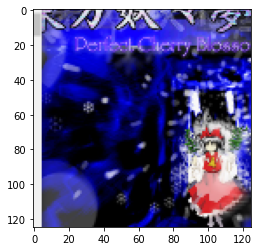

In [3]:
#keep running this cell until the window is centered on the main screen (not the score/side)
#shrink is the image resize (down) ratio (leads to faster processing speeds but worse resolution)
shrink = 4
#I cant remember why this is a loop...
for i in range(1):
    #The area of the screen we care about, move the window around until it's centered
    cords = {'top': 360 , 'left': 1160 , 'width': 500, 'height': 500 }
    with mss() as sct :
        bgr = np.array(sct.grab(cords))
    img = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    #Compress the image by the shrink factor
    img = cv2.resize(img, dsize=(int(500/shrink), int(500/shrink)), \
                     interpolation=None)
    img = np.array(img)
    #use this to find the character so you can save an image of her
    plt.imshow(img[98:106,58:63])
    #For now just show the whole screen
    plt.imshow(img)


In [4]:
#if you don't use a preloaded character, save a new one here

#character = (img[98:106,58:63])

# f = open('.pckl', 'wb')
# pickle.dump(character, f)
# f.close()

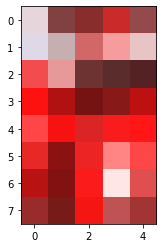

In [5]:
#Looks just like her
plt.imshow(character)

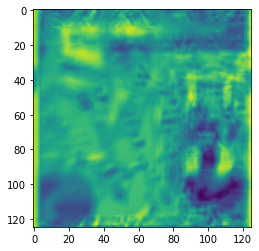

In [6]:
#Should be the same ratio as before, not sure why I'm redefining this...
shrink = 4
cords = {'top': 360 , 'left': 1160 , 'width': 500, 'height': 500 }
for i in range(2):    
    with mss() as sct :
        bgr = np.array(sct.grab(cords))
    img = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, dsize=(int(500/shrink), int(500/shrink)), \
                     interpolation=None)
    img = np.array(img).astype(int)

    character_map = []
    for i in range(len(character)):
        for j in range(len(character[0])):
            unrolled = (np.square(np.sum((np.absolute(np.absolute(character[i,j]-img))),axis=2)))
            rolled_x = np.roll(unrolled,-i,axis=0)
            rolled_xy = np.roll(rolled_x,-j,axis=1)
            character_map.append(rolled_xy)
    character_map = np.array(character_map)
    character_map = (np.sum(character_map,axis=0))

    y_offset,x_offset = np.unravel_index(np.argmin(character_map, axis=None), \
                                                 character_map.shape)

    pyautogui.moveTo(cords['left']+x_offset*shrink,\
                     cords['top']+y_offset*shrink)

#Dark blue means that's where the program thinks the character is
plt.imshow(character_map)

In [7]:
#Get the character's position
def get_pos(move_mouse=False):
    with mss() as sct :
        bgr = np.array(sct.grab(cords))
    img = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, dsize=(int(500/shrink), int(500/shrink)), \
                     interpolation=None)
    img = np.array(img).astype(int)

    character_map = []
    for i in range(len(character)):
        for j in range(len(character[0])):
            unrolled = (np.square(np.sum((np.absolute(np.absolute(character[i,j]-img))),axis=2)))
            rolled_x = np.roll(unrolled,-i,axis=0)
            rolled_xy = np.roll(rolled_x,-j,axis=1)
            character_map.append(rolled_xy)
    character_map = np.array(character_map)
    character_map = (np.sum(character_map,axis=0))

    y_offset,x_offset = np.unravel_index(np.argmin(character_map, axis=None), \
                                                 character_map.shape)
    #Move the mouse there to show that we found the character
    if move_mouse:
        pyautogui.moveTo(cords['left']+x_offset*shrink,\
                        cords['top']+y_offset*shrink)
    return (y_offset,x_offset,img)
get_pos(move_mouse=True)

(106,
 96,
 array([[[241, 241, 241],
         [241, 241, 241],
         [241, 241, 241],
         ...,
         [163, 105, 215],
         [179, 120, 227],
         [ 89,  59, 113]],
 
        [[241, 241, 241],
         [241, 241, 241],
         [241, 241, 241],
         ...,
         [124, 157, 234],
         [169, 140, 230],
         [119, 166, 196]],
 
        [[241, 241, 241],
         [241, 241, 241],
         [241, 241, 241],
         ...,
         [115, 195, 216],
         [120, 183, 214],
         [182, 122, 201]],
 
        ...,
 
        [[241, 241, 241],
         [241, 241, 241],
         [241, 241, 241],
         ...,
         [ 35,  34, 129],
         [ 28,  29, 144],
         [ 24,  24, 154]],
 
        [[241, 241, 241],
         [241, 241, 241],
         [241, 241, 241],
         ...,
         [ 30,  31, 136],
         [ 28,  30, 152],
         [ 24,  24, 157]],
 
        [[241, 241, 241],
         [241, 241, 241],
         [241, 241, 241],
         ...,
         [ 31,  3

In [8]:
#Look in each cardinal direction with some upwards bias to account for the screen scroll
#These are just for displaying to the user
def TOP_SQUARE_IMG(img,center,bias,radial_bias,radius):
    top_wall = center[0]-radius*2-bias[0]-radial_bias
    left_wall = center[1]+bias[1]-radius
    square = img[top_wall:top_wall+radius*2, left_wall:left_wall+radius*2]
    return((square))
    
def BOTTOM_SQUARE_IMG(img,center,bias,radial_bias,radius):
    top_wall = center[0]-bias[0]+radial_bias+6
    left_wall = center[1]+bias[1]-radius
    square = img[top_wall:top_wall+radius*2, left_wall:left_wall+radius*2]

    return((square))
    
def LEFT_SQUARE_IMG(img,center,bias,radial_bias,radius):
    top_wall = center[0]-bias[0]-radius
    left_wall = center[1]+bias[1]-radial_bias-radius*2
    square = img[top_wall:top_wall+radius*2, left_wall:left_wall+radius*2]
    return((square))
    
def RIGHT_SQUARE_IMG(img,center,bias,radial_bias,radius):
    top_wall = center[0]-bias[0]-radius
    left_wall = center[1]+bias[1]+radial_bias
    square = img[top_wall:top_wall+radius*2, left_wall:left_wall+radius*2]
    return((square))


In [9]:
#Avoid the messy direction (probably more bullets)
def square_noise(square):
    noise =  np.sum(np.square(np.sum(np.absolute(square\
                                               - square.mean(axis=(0,1))),\
                                   axis=2)))
    white = np.count_nonzero((np.max(square,axis=2)).flatten()>230)+5
    return noise*white

screen_center = (int(500/shrink/2),int(500/shrink/2))
center = (y_offset,x_offset)
#We want the square to be shifted upwards beacuase that's the scroll direction
#I can't remember why there is an x_offset
bias = (5,3)
#We want the square to be away from the character (radial bias)
radial_bias = 6
#Size of the square
radius = 10

#Cardinal directions plus diagonal
def TOP_SQUARE(img,center,bias,radial_bias,radius):
    top_wall = center[0]-radius*2-bias[0]-radial_bias
    left_wall = center[1]+bias[1]-radius
    square = img[top_wall:top_wall+radius*2, left_wall:left_wall+radius*2]
    if square.shape==(radius*2,radius*2,3):
        return(square_noise(square))
    else:
        #Return inf if too close to wall
        return(float('inf'))
    
def TL_SQUARE(img,center,bias,radial_bias,radius):
    top_wall = int(((center[0]-radius*2-bias[0]-radial_bias)\
         +(center[0]-bias[0]-radius))/2)
    left_wall = int(((center[1]+bias[1]-radius)\
         +(center[1]+bias[1]-radial_bias-radius*2))/2)
    square = img[top_wall:top_wall+radius*2, left_wall:left_wall+radius*2]
    if square.shape==(radius*2,radius*2,3):
        return(square_noise(square))
    else:
        return(float('inf'))
    
def BL_SQUARE(img,center,bias,radial_bias,radius):
    top_wall = int(((center[0]-bias[0]+radial_bias+13)\
         +(center[0]-bias[0]-radius))/2)
    left_wall = int(((center[1]+bias[1]-radius)\
         +(center[1]+bias[1]-radial_bias-radius*2))/2)
    square = img[top_wall:top_wall+radius*2, left_wall:left_wall+radius*2]
    if square.shape==(radius*2,radius*2,3):
        return(square_noise(square))
    else:
        return(float('inf'))
    
def TR_SQUARE(img,center,bias,radial_bias,radius):
    top_wall = int(((center[0]-radius*2-bias[0]-radial_bias)\
         +(center[0]-bias[0]-radius))/2)
    left_wall = int(((center[1]+bias[1]-radius)\
         +(center[1]+bias[1]+radial_bias))/2)
    square = img[top_wall:top_wall+radius*2, left_wall:left_wall+radius*2]
    if square.shape==(radius*2,radius*2,3):
        return(square_noise(square))
    else:
        return(float('inf'))
    
def BR_SQUARE(img,center,bias,radial_bias,radius):
    top_wall = int(((center[0]-bias[0]+radial_bias+13)\
         +(center[0]-bias[0]-radius))/2)
    left_wall = int(((center[1]+bias[1]-radius)\
         +(center[1]+bias[1]+radial_bias))/2)
    square = img[top_wall:top_wall+radius*2, left_wall:left_wall+radius*2]
    if square.shape==(radius*2,radius*2,3):
        return(square_noise(square))
    else:
        return(float('inf'))
    
def BOTTOM_SQUARE(img,center,bias,radial_bias,radius):
    top_wall = center[0]-bias[0]+radial_bias+6
    left_wall = center[1]+bias[1]-radius
    square = img[top_wall:top_wall+radius*2, left_wall:left_wall+radius*2]

    if square.shape==(radius*2,radius*2,3):
        return(square_noise(square))
    else:
        return(float('inf'))
    
def LEFT_SQUARE(img,center,bias,radial_bias,radius):
    top_wall = center[0]-bias[0]-radius
    left_wall = center[1]+bias[1]-radial_bias-radius*2
    square = img[top_wall:top_wall+radius*2, left_wall:left_wall+radius*2]
    if square.shape==(radius*2,radius*2,3):
        return(square_noise(square))
    else:
        return(float('inf'))
    
def RIGHT_SQUARE(img,center,bias,radial_bias,radius):
    top_wall = center[0]-bias[0]-radius
    left_wall = center[1]+bias[1]+radial_bias
    square = img[top_wall:top_wall+radius*2, left_wall:left_wall+radius*2]
    if square.shape==(radius*2,radius*2,3):
        return(square_noise(square))
    else:
        return(float('inf'))


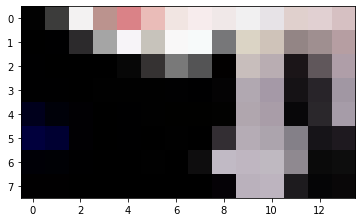

In [10]:
center = (y_offset,x_offset)
bias = (0,3)
radial_bias = 5
radius = 7
square = (BOTTOM_SQUARE_IMG(img,center,bias,radial_bias,radius))
np.count_nonzero((np.max(square,axis=2)).flatten()>230)
plt.imshow(square)

In [11]:
l = (LEFT_SQUARE(img,center,bias,radial_bias,radius))
r = (RIGHT_SQUARE(img,center,bias,radial_bias,radius))
t = (TOP_SQUARE(img,center,bias,radial_bias,radius))
b = (BOTTOM_SQUARE(img,center,bias,radial_bias,radius))
tl = (TL_SQUARE(img,center,bias,radial_bias,radius))
tr = (TR_SQUARE(img,center,bias,radial_bias,radius))
bl = (BL_SQUARE(img,center,bias,radial_bias,radius))
br = (BR_SQUARE(img,center,bias,radial_bias,radius))
directions = (l,r,t,b,tl,tr,bl,br)
direction = directions.index(min(directions))
#This is the "messiness" of each direction
#Inf means the character is too far in that direction and would hit the wall
print(directions)

(46510047.09839651,
 226996236.834444,
 377998615.3659933,
 inf,
 469485524.7407331,
 299306904.0049979,
 106746785.07913369,
 138852999.88494375)

In [13]:
for arrowkey in [U,D,L,R,Z,CTRL]:
    ReleaseKey(arrowkey)
    
bias = (5,3)
radial_bias = 6
radius = 10
press_time = 0.025

bias = (2,3)
radial_bias = 5
radius = 7

time.sleep(5)


#Amount of time to run
for i in range(10000):
    try:
        if i%100==0:
            PressKey(Z)
            PressKey(CTRL)
        (y_offset,x_offset,img) = get_pos()
        center = (y_offset,x_offset)

        l = (LEFT_SQUARE(img,center,bias,radial_bias,radius))
        r = (RIGHT_SQUARE(img,center,bias,radial_bias,radius))
        t = (TOP_SQUARE(img,center,bias,radial_bias,radius))
        b = (BOTTOM_SQUARE(img,center,bias,radial_bias,radius))
        tl = (TL_SQUARE(img,center,bias,radial_bias,radius))
        tr = (TR_SQUARE(img,center,bias,radial_bias,radius))
        bl = (BL_SQUARE(img,center,bias,radial_bias,radius))
        br = (BR_SQUARE(img,center,bias,radial_bias,radius))
        directions = (l,r,t,b,tl,tr,bl,br)
        direction = directions.index(min(directions))
        if direction<4:
            arrowkey = [L,R,U,D][direction]
            PressKey(arrowkey)
            time.sleep(press_time)
            ReleaseKey(arrowkey)
        elif direction==4:
            PressKey(U)
            PressKey(L)
            time.sleep(press_time)
            ReleaseKey(U)
            ReleaseKey(L)
        elif direction==5:
            PressKey(U)
            PressKey(R)
            time.sleep(press_time)
            ReleaseKey(U)
            ReleaseKey(R)
        elif direction==6:
            PressKey(D)
            PressKey(L)
            time.sleep(press_time)
            ReleaseKey(D)
            ReleaseKey(L)
        elif direction==7:
            PressKey(D)
            PressKey(R)
            time.sleep(press_time)
            ReleaseKey(D)
            ReleaseKey(R)
    #If you don't release keys on keyboard interrupt you have to press each one that is held down
    except KeyboardInterrupt:
        for arrowkey in [U,D,L,R,Z,CTRL]:
            ReleaseKey(arrowkey)
        break
        
for arrowkey in [U,D,L,R,Z,CTRL]:
    ReleaseKey(arrowkey)